In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

In [13]:
# # OAI dataset
# df = pd.read_csv("preprocessed_OAI.csv")
# # GLAD dataset
# dfg = pd.read_csv("preprocessed_Glad.csv")
# df.shape
# print("OAI shape:", df.shape, "GLAD shape:", dfg.shape)

OAI shape: (4131, 11) GLAD shape: (7603, 11)


In [14]:
df.columns

Index(['V00AGE', 'P02SEX', 'P01BMI', 'V00CESD6', 'V00CEMPLOY_employment',
       'PA_baseline_category', 'PA_followup_category', 'V00KOOSQOL',
       'V01KOOSQOL', 'knee_pain_baseline', 'knee_pain_follow'],
      dtype='object')

In [15]:
dfg

,age,gender,fysb_BMI,ptb_14618_depression,ptb_3777_employment,ptb_4145,pt12_4145,ptb_koos_qol_score,pt12_koos_qol_score,ptb_3764,pt12_3764
0,50,2,22.68,1.0,1.0,10.0,10.0,31.25,56.25,65.0,17.0
1,45,1,29.07,1.0,1.0,7.0,10.0,25.00,43.75,96.0,52.0
2,46,2,26.10,1.0,1.0,3.0,9.0,68.75,62.50,39.0,25.0
3,53,2,28.03,1.0,1.0,4.0,4.0,62.50,87.50,15.0,2.0
4,68,2,27.82,1.0,1.0,8.0,10.0,87.50,93.75,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1.0,1.0,8.0,10.0,50.00,56.25,57.0,9.0
7599,61,2,29.34,1.0,1.0,3.0,6.0,25.00,68.75,55.0,8.0
7600,62,1,25.88,1.0,1.0,3.0,3.0,50.00,25.00,26.0,77.0
7601,47,2,26.51,1.0,1.0,4.0,2.0,43.75,18.75,47.0,92.0


##### Rename columns

In [16]:
# Renaming columns in df for consistency
df.rename(columns={
    'V00AGE': 'Age',
    'P02SEX': 'Gender',
    'P01BMI': 'BMI',
    'V00CESD6': 'Depression',
    'V00CEMPLOY_employment': 'Employment_status',
    'V00KOOSQOL': 'Baseline_Quality_of_life',
    'V01KOOSQOL': 'Followup_Quality_of_life',
    'knee_pain_baseline': 'Baseline_Pain',
    'knee_pain_follow': 'Followup_Pain',
    'PA_baseline_category': 'Baseline_Physical_Activity',
    'PA_followup_category': 'Followup_Physical_Activity'
}, inplace=True)

dfg.rename(columns={
    'age': 'Age',
    'gender': 'Gender',
    'fysb_BMI': 'BMI',
    'ptb_14618_depression': 'Depression',
    'ptb_3777_employment': 'Employment_status',
    'ptb_koos_qol_score': 'Baseline_Quality_of_life',
    'pt12_koos_qol_score': 'Followup_Quality_of_life',
    'ptb_3764': 'Baseline_Pain',
    'pt12_3764': 'Followup_Pain',
    'ptb_4145': 'Baseline_Physical_Activity',
    'pt12_4145': 'Followup_Physical_Activity'
}, inplace=True)


##### Create outcome

In [17]:
# OAI dataset
##### Physical activity
# Ensure the columns are of type 'category'
df['Followup_Physical_Activity'] = df['Followup_Physical_Activity'].astype('category')
df['Baseline_Physical_Activity'] = df['Baseline_Physical_Activity'].astype('category')

# Convert categories to codes if they are ordinal
df['Followup_Physical_Activity'] = df['Followup_Physical_Activity'].cat.codes
df['Baseline_Physical_Activity'] = df['Baseline_Physical_Activity'].cat.codes

df['PA_change'] = df['Followup_Physical_Activity'] - df['Baseline_Physical_Activity']

##### Quality of life
df['QOL_change'] = df['Followup_Quality_of_life'] - df['Baseline_Quality_of_life']

##### Pain
df['pain_change'] = df['Followup_Pain'] - df['Baseline_Pain']

In [18]:
dfg

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Followup_Quality_of_life,Baseline_Pain,Followup_Pain
0,50,2,22.68,1.0,1.0,10.0,10.0,31.25,56.25,65.0,17.0
1,45,1,29.07,1.0,1.0,7.0,10.0,25.00,43.75,96.0,52.0
2,46,2,26.10,1.0,1.0,3.0,9.0,68.75,62.50,39.0,25.0
3,53,2,28.03,1.0,1.0,4.0,4.0,62.50,87.50,15.0,2.0
4,68,2,27.82,1.0,1.0,8.0,10.0,87.50,93.75,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1.0,1.0,8.0,10.0,50.00,56.25,57.0,9.0
7599,61,2,29.34,1.0,1.0,3.0,6.0,25.00,68.75,55.0,8.0
7600,62,1,25.88,1.0,1.0,3.0,3.0,50.00,25.00,26.0,77.0
7601,47,2,26.51,1.0,1.0,4.0,2.0,43.75,18.75,47.0,92.0


In [19]:
# GLAD Dataset
##### Physical activity
dfg['Baseline_Physical_Activity'] = dfg['Baseline_Physical_Activity'].astype('category')
dfg['Baseline_Physical_Activity'] = dfg['Baseline_Physical_Activity'].cat.codes

dfg['Followup_Physical_Activity'] = dfg['Followup_Physical_Activity'].astype('category')
dfg['Followup_Physical_Activity'] = dfg['Followup_Physical_Activity'].cat.codes

dfg['PA_change'] = dfg['Followup_Physical_Activity'] - dfg['Baseline_Physical_Activity']

##### Quality of life
dfg['QOL_change'] = dfg['Followup_Quality_of_life'] - dfg['Baseline_Quality_of_life']

##### Pain
dfg['pain_change'] = dfg['Followup_Pain'] - dfg['Baseline_Pain']


In [20]:
df.columns

Index(['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
       'Baseline_Physical_Activity', 'Followup_Physical_Activity',
       'Baseline_Quality_of_life', 'Followup_Quality_of_life', 'Baseline_Pain',
       'Followup_Pain', 'PA_change', 'QOL_change', 'pain_change'],
      dtype='object')

In [21]:
dfg.columns

Index(['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
       'Baseline_Physical_Activity', 'Followup_Physical_Activity',
       'Baseline_Quality_of_life', 'Followup_Quality_of_life', 'Baseline_Pain',
       'Followup_Pain', 'PA_change', 'QOL_change', 'pain_change'],
      dtype='object')

In [46]:
df.columns

Index(['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
       'Baseline_Physical_Activity', 'Followup_Physical_Activity',
       'Baseline_Quality_of_life', 'Followup_Quality_of_life', 'Baseline_Pain',
       'Followup_Pain', 'PA_change', 'QOL_change', 'pain_change', 'treatment',
       'weights'],
      dtype='object')

##### Combine DataFrames and Prepare Data

/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_85405/969596486.py:30: RuntimeWarning: invalid value encountered in log
  return np.sum(w * np.log(w))


Iteration limit reached    (Exit mode 9)
            Current function value: 1684.4029912571468
            Iterations: 100
            Function evaluations: 413588
            Gradient evaluations: 100
    Age  Gender   BMI  Depression  Employment_status  \
0  78.0     1.0  27.6         1.0                3.0   
1  76.0     2.0  27.4         1.0                3.0   
2  69.0     1.0  29.8         1.0                3.0   
3  68.0     2.0  30.1         2.0                3.0   
4  76.0     1.0  32.4         1.0                2.0   

   Baseline_Physical_Activity  Followup_Physical_Activity  \
0                           0                           0   
1                           0                           2   
2                           0                           3   
3                           0                           0   
4                           0                           0   

   Baseline_Quality_of_life  Followup_Quality_of_life  Baseline_Pain  \
0                    

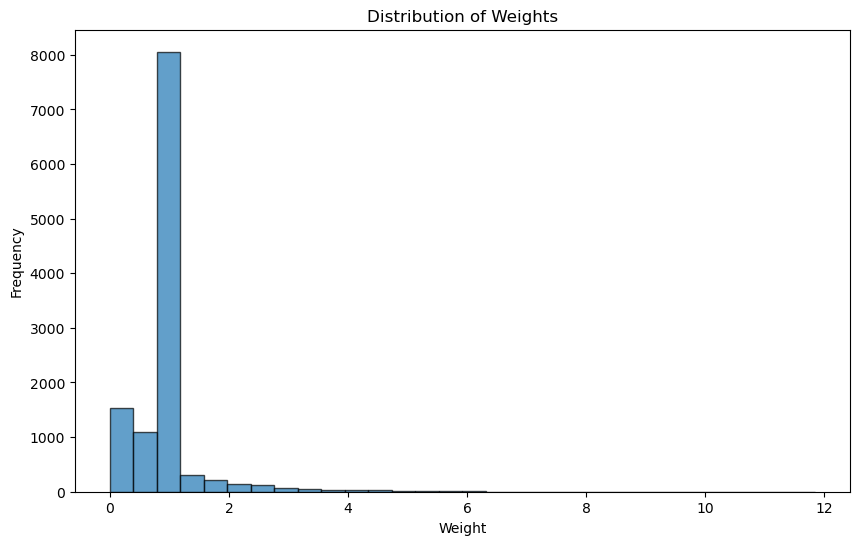

                            WLS Regression Results                            
Dep. Variable:              PA_change   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     68.26
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.58e-16
Time:                        12:05:08   Log-Likelihood:                -25439.
No. Observations:               11734   AIC:                         5.088e+04
Df Residuals:                   11732   BIC:                         5.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0350      0.030      1.153      0.2

In [22]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming df and dfg are already defined
# Add treatment indicators
df['treatment'] = 0  # Control group
dfg['treatment'] = 1  # Treatment group

# Define the covariates for matching
matching_vars = ['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
                 'Baseline_Physical_Activity', 'Baseline_Quality_of_life', 'Baseline_Pain']

# Create matrix of matching variables for the control group
X_control = df[matching_vars].values

# Define the treatment indicator for the control group (all zeros)
D_control = np.zeros(len(df))

# Define the covariates for the treatment group (to match)
X_treatment = dfg[matching_vars].values

def entropy_balance(D_control, X_control, X_treatment):
    # Initial weights for the control group
    initial_weights = np.ones(len(X_control))

    def objective(w):
        return np.sum(w * np.log(w))

    def constraints(w):
        treated_mean = np.mean(X_treatment, axis=0)
        control_mean_weighted = np.dot(w, X_control) / np.sum(w)
        return treated_mean - control_mean_weighted

    # Define constraint dictionary
    cons = [{'type': 'eq', 'fun': constraints}]

    # Minimize the objective function
    result = minimize(objective, initial_weights, constraints=cons, method='SLSQP', options={'disp': True})

    return result.x

# Calculate the weights for the control group
weights_control = entropy_balance(D_control, X_control, X_treatment)

# Add weights to the control group dataframe
df['weights'] = weights_control

# Add a weight of 1 to all treatment group observations
dfg['weights'] = 1

# Combine the datasets after weighting
data_balanced = pd.concat([df, dfg])

# Save the new weighted dataset to a CSV file
data_balanced.to_csv('weighted_dataset_separate.csv', index=False)




In [24]:
# Display the first few rows of the new weighted dataset
data_balanced

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Followup_Quality_of_life,Baseline_Pain,Followup_Pain,PA_change,QOL_change,pain_change,treatment,weights
0,78.0,1.0,27.60,1.0,3.0,0,0,50.00,68.75,8.0,5.0,0,18.75,-3.0,0,3.131650
1,76.0,2.0,27.40,1.0,3.0,0,2,100.00,62.50,0.0,4.0,2,-37.50,4.0,0,0.414970
2,69.0,1.0,29.80,1.0,3.0,0,3,81.25,100.00,1.0,0.0,3,18.75,-1.0,0,0.278891
3,68.0,2.0,30.10,2.0,3.0,0,0,75.00,81.25,3.0,3.0,0,6.25,0.0,0,0.670219
4,76.0,1.0,32.40,1.0,2.0,0,0,75.00,68.75,3.0,4.0,0,-6.25,1.0,0,0.829849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7598,55.0,2.0,35.63,1.0,1.0,7,9,50.00,56.25,57.0,9.0,2,6.25,-48.0,1,1.000000
7599,61.0,2.0,29.34,1.0,1.0,2,5,25.00,68.75,55.0,8.0,3,43.75,-47.0,1,1.000000
7600,62.0,1.0,25.88,1.0,1.0,2,2,50.00,25.00,26.0,77.0,0,-25.00,51.0,1,1.000000
7601,47.0,2.0,26.51,1.0,1.0,3,1,43.75,18.75,47.0,92.0,-2,-25.00,45.0,1,1.000000


In [26]:
# Summary statistics of the weights
print(data_balanced['weights'].describe())


count    11734.000000
mean         0.976384
std          0.653016
min          0.000902
25%          1.000000
50%          1.000000
75%          1.000000
max         11.835992
Name: weights, dtype: float64


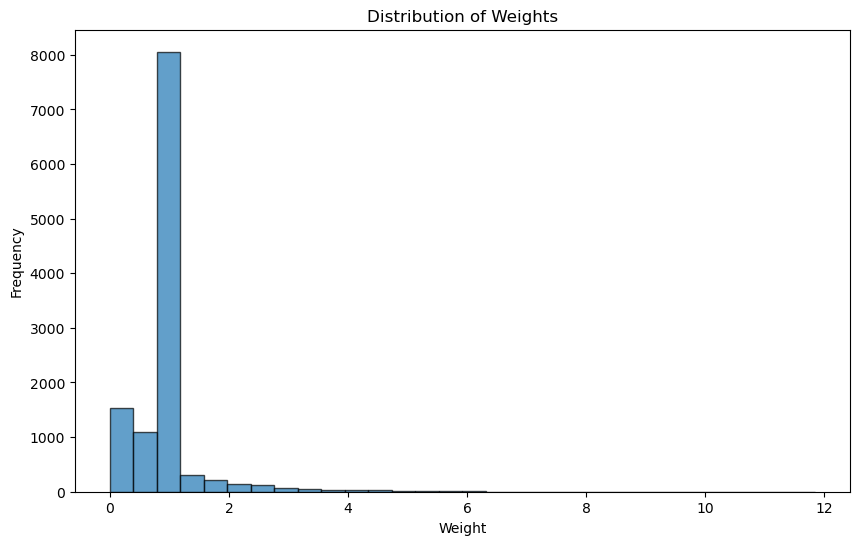

In [27]:
# Plot histogram of the weights
plt.figure(figsize=(10, 6))
plt.hist(data_balanced['weights'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

In [28]:
# Define the outcome and treatment
Y_balanced = data_balanced['PA_change']
D_balanced = data_balanced['treatment']

# Add constant for the intercept
X_balanced = sm.add_constant(D_balanced)

# Fit the weighted linear model
model = sm.WLS(Y_balanced, X_balanced, weights=data_balanced['weights'])
results = model.fit()

# Print the summary
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              PA_change   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     68.26
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.58e-16
Time:                        12:40:43   Log-Likelihood:                -25439.
No. Observations:               11734   AIC:                         5.088e+04
Df Residuals:                   11732   BIC:                         5.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0350      0.030      1.153      0.2

In [69]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Example data for control group (df)
df = pd.DataFrame({
    'Age': [35, 45, 50, 60, 65],
    'Gender': [0, 1, 0, 1, 0],
    'BMI': [22, 25, 27, 30, 24],
    'Depression': [0, 1, 0, 1, 0],
    'Employment_status': [1, 0, 1, 0, 1],
    'Baseline_Physical_Activity': [10, 20, 15, 30, 25],
    'Followup_Physical_Activity': [15, 25, 20, 35, 30],
    'Baseline_Quality_of_life': [70, 60, 65, 75, 80],
    'Baseline_Pain': [3, 5, 2, 4, 3],
    'PA_change': [5, 5, 5, 5, 5]
})

# Example data for treatment group (dfg)
dfg = pd.DataFrame({
    'Age': [30, 40, 55, 65, 70],
    'Gender': [1, 0, 1, 0, 1],
    'BMI': [23, 26, 28, 31, 25],
    'Depression': [1, 0, 1, 0, 1],
    'Employment_status': [0, 1, 0, 1, 0],
    'Baseline_Physical_Activity': [12, 18, 14, 28, 26],
    'Followup_Physical_Activity': [17, 23, 19, 33, 29],
    'Baseline_Quality_of_life': [68, 62, 63, 78, 75],
    'Baseline_Pain': [4, 3, 3, 5, 2],
    'PA_change': [5, 5, 5, 5, 3]
})

# Add treatment indicator
df['Treatment'] = 0  # Control group
dfg['Treatment'] = 1  # Treatment group

# Combine the datasets
combined_data = pd.concat([df, dfg], ignore_index=True)

# Define covariates and outcome
covariates = ['Age', 'Gender', 'BMI', 'Depression', 'Employment_status', 
              'Baseline_Physical_Activity', 'Baseline_Quality_of_life', 'Baseline_Pain']
outcome = 'PA_change'
treatment = 'Treatment'

# Separate treatment and control groups
control_data = combined_data[combined_data[treatment] == 0]
treatment_data = combined_data[combined_data[treatment] == 1]

# Calculate target moments from the treatment group
target_means = treatment_data[covariates].mean()

# Define the objective function for optimization
def objective(weights):
    weighted_covariates = control_data[covariates].multiply(weights, axis=0)
    weighted_means = weighted_covariates.mean()
    return np.sum((weighted_means - target_means) ** 2)

# Initial weights
initial_weights = np.ones(len(control_data))

# Constraints: weights should sum to the number of control units
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - len(control_data)})

# Bounds: weights should be non-negative
bounds = [(0, None) for _ in range(len(control_data))]

# Optimize weights
result = minimize(objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)

# Get the optimized weights
optimized_weights = result.x

# Ensure weights are positive and normalized
control_data['weights'] = np.abs(optimized_weights)
control_data['weights'] = control_data['weights'] / np.sum(control_data['weights']) * len(control_data)

# Check for NaN values in weights
if np.any(np.isnan(control_data['weights'])):
    print("NaN values found in weights. Recalculating weights to handle numerical issues.")
    control_data['weights'].fillna(1, inplace=True)
    control_data['weights'] = control_data['weights'] / np.sum(control_data['weights']) * len(control_data)

# Combine the weighted control group with the treatment group
combined_weighted_data = pd.concat([control_data, treatment_data], ignore_index=True)

# Check for NaN values in the combined data
combined_weighted_data = combined_weighted_data.dropna()

# Add a constant term for the regression
combined_weighted_data = sm.add_constant(combined_weighted_data, has_constant='add')

# Check for multicollinearity using VIF
X = combined_weighted_data[['const', treatment]]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

# If VIF values are acceptable, fit the model using Ridge regression as a robust method
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(combined_weighted_data[['const', treatment]], combined_weighted_data[outcome], sample_weight=combined_weighted_data['weights'])

# Print the coefficients
print("Ridge Regression Coefficients:")
print(ridge_model.coef_)
print("Intercept:", ridge_model.intercept_)


     feature  VIF
0      const  1.0
1  Treatment  NaN
Ridge Regression Coefficients:
[0. 0.]
Intercept: 5.0


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_85405/915877627.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['weights'] = np.abs(optimized_weights)
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_85405/915877627.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['weights'] = control_data['weights'] / np.sum(control_data['weights']) * len(control_data)
/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/statsmodels/regression/linear

In [71]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Example data for control group (df)
df = pd.DataFrame({
    'Age': [35, 45, 50, 60, 65],
    'Gender': [0, 1, 0, 1, 0],
    'BMI': [22, 25, 27, 30, 24],
    'Depression': [0, 1, 0, 1, 0],
    'Employment_status': [1, 0, 1, 0, 1],
    'Baseline_Physical_Activity': [10, 20, 15, 30, 25],
    'Followup_Physical_Activity': [15, 25, 20, 35, 30],
    'Baseline_Quality_of_life': [70, 60, 65, 75, 80],
    'Baseline_Pain': [3, 5, 2, 4, 3],
    'PA_change': [5, 5, 5, 5, 5]
})

# Example data for treatment group (dfg)
dfg = pd.DataFrame({
    'Age': [30, 40, 55, 65, 70],
    'Gender': [1, 0, 1, 0, 1],
    'BMI': [23, 26, 28, 31, 25],
    'Depression': [1, 0, 1, 0, 1],
    'Employment_status': [0, 1, 0, 1, 0],
    'Baseline_Physical_Activity': [12, 18, 14, 28, 26],
    'Followup_Physical_Activity': [17, 23, 19, 33, 29],
    'Baseline_Quality_of_life': [68, 62, 63, 78, 75],
    'Baseline_Pain': [4, 3, 3, 5, 2],
    'PA_change': [5, 5, 5, 5, 3]
})

# Add treatment indicator
df['Treatment'] = 0  # Control group
dfg['Treatment'] = 1  # Treatment group

# Combine the datasets
combined_data = pd.concat([df, dfg], ignore_index=True)

# Define covariates and outcome
covariates = ['Age', 'Gender', 'BMI', 'Depression', 'Employment_status', 
              'Baseline_Physical_Activity', 'Baseline_Quality_of_life', 'Baseline_Pain']
outcome = 'PA_change'
treatment = 'Treatment'

# Separate treatment and control groups
control_data = combined_data[combined_data[treatment] == 0]
treatment_data = combined_data[combined_data[treatment] == 1]

# Calculate target moments from the treatment group
target_means = treatment_data[covariates].mean()

# Define the objective function for optimization
def objective(weights):
    weighted_covariates = control_data[covariates].multiply(weights, axis=0)
    weighted_means = weighted_covariates.mean()
    return np.sum((weighted_means - target_means) ** 2)

# Initial weights
initial_weights = np.ones(len(control_data))

# Constraints: weights should sum to the number of control units
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - len(control_data)})

# Bounds: weights should be non-negative
bounds = [(0, None) for _ in range(len(control_data))]

# Optimize weights
result = minimize(objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)

# Get the optimized weights
optimized_weights = result.x

# Ensure weights are positive and normalized
control_data['weights'] = np.abs(optimized_weights)
control_data['weights'] = control_data['weights'] / np.sum(control_data['weights']) * len(control_data)

# Check for NaN values in weights
if np.any(np.isnan(control_data['weights'])):
    print("NaN values found in weights. Recalculating weights to handle numerical issues.")
    control_data['weights'].fillna(1, inplace=True)
    control_data['weights'] = control_data['weights'] / np.sum(control_data['weights']) * len(control_data)

# Apply weights to each observation in the control group
weighted_control_data = control_data.copy()
for col in covariates + [outcome]:
    weighted_control_data[col] = weighted_control_data[col] * weighted_control_data['weights']

# Drop the weights column for clarity
weighted_control_data = weighted_control_data.drop(columns=['weights'])

# Print the new DataFrame with weighted control group


# Save the new DataFrame to a CSV file (optional)
# weighted_control_data.to_csv("weighted_control_data.csv", index=False)


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_85405/420761354.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['weights'] = np.abs(optimized_weights)
/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_85405/420761354.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['weights'] = control_data['weights'] / np.sum(control_data['weights']) * len(control_data)


In [72]:
weighted_control_data

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Baseline_Pain,PA_change,Treatment
0,19.480845,0.000000,12.245102,0.000000,0.556596,5.565956,15,38.961689,1.669787,2.782978,0
1,27.507243,0.611272,15.281802,0.611272,0.000000,12.225441,25,36.676324,3.056360,3.056360,0
2,102.170195,0.000000,55.171906,0.000000,2.043404,30.651059,20,132.821254,4.086808,10.217020,0
3,69.563398,1.159390,34.781699,1.159390,0.000000,34.781699,35,86.954248,4.637560,5.796950,0
4,40.907002,0.000000,15.104124,0.000000,0.629338,15.733462,30,50.347080,1.888015,3.146692,0


In [73]:
df

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Baseline_Pain,PA_change,Treatment
0,35,0,22,0,1,10,15,70,3,5,0
1,45,1,25,1,0,20,25,60,5,5,0
2,50,0,27,0,1,15,20,65,2,5,0
3,60,1,30,1,0,30,35,75,4,5,0
4,65,0,24,0,1,25,30,80,3,5,0


In [74]:
dfg

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Baseline_Pain,PA_change,Treatment
0,30,1,23,1,0,12,17,68,4,5,1
1,40,0,26,0,1,18,23,62,3,5,1
2,55,1,28,1,0,14,19,63,3,5,1
3,65,0,31,0,1,28,33,78,5,5,1
4,70,1,25,1,0,26,29,75,2,3,1


In [75]:
optimized_weights

array([0.55659556, 0.61127207, 2.04340391, 1.15938997, 0.6293385 ])

In [84]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Example data for control group (df)
df = pd.DataFrame({
    'Age': [35, 45, 50, 60, 65],
    'Gender': [0, 1, 0, 1, 0],
    'BMI': [22, 25, 27, 30, 24],
    'Depression': [0, 1, 0, 1, 0],
    'Employment_status': [1, 0, 1, 0, 1],
    'Baseline_Physical_Activity': [10, 20, 15, 30, 25],
    'Followup_Physical_Activity': [15, 25, 20, 35, 30],
    'Baseline_Quality_of_life': [70, 60, 65, 75, 80],
    'Baseline_Pain': [3, 5, 2, 4, 3],
    'PA_change': [5, 5, 5, 5, 5]
})

# Example data for treatment group (dfg)
dfg = pd.DataFrame({
    'Age': [30, 40, 55, 65, 70],
    'Gender': [1, 0, 1, 0, 1],
    'BMI': [23, 26, 28, 31, 25],
    'Depression': [1, 0, 1, 0, 1],
    'Employment_status': [0, 1, 0, 1, 0],
    'Baseline_Physical_Activity': [12, 18, 14, 28, 26],
    'Followup_Physical_Activity': [17, 23, 19, 33, 29],
    'Baseline_Quality_of_life': [68, 62, 63, 78, 75],
    'Baseline_Pain': [4, 3, 3, 5, 2],
    'PA_change': [5, 5, 5, 5, 3]
})

# Extract features and treatment indicator
features = ['Age', 'Gender', 'BMI', 'Depression', 'Employment_status', 'Baseline_Physical_Activity', 'Baseline_Quality_of_life', 'Baseline_Pain']
X_control = df[features].values
X_treatment = dfg[features].values

# Balance conditions: means of control and treatment groups should match
mean_treatment = X_treatment.mean(axis=0)

# Entropy balancing objective and constraints
def entropy_balancing(weights, X_control, mean_treatment):
    weighted_mean_control = np.average(X_control, axis=0, weights=weights)
    constraint = weighted_mean_control - mean_treatment
    return np.sum(weights * np.log(weights)), constraint

# Initial weights
initial_weights = np.ones(len(X_control)) / len(X_control)

# Constraint function
def constraints(weights):
    return entropy_balancing(weights, X_control, mean_treatment)[1]

# Optimization
result = minimize(
    lambda w: entropy_balancing(w, X_control, mean_treatment)[0],
    initial_weights,
    constraints={'type': 'eq', 'fun': constraints},
    bounds=[(0, None)] * len(X_control)
)

optimal_weights = result.x

# Apply weights to control group
df['weights'] = optimal_weights

# Display weights
print(df[['weights']])


   weights
0      0.2
1      0.2
2      0.2
3      0.2
4      0.2


In [85]:
# Function to create a new DataFrame with rows replicated according to weights
def create_weighted_df(df, weight_column='weights'):
    # Normalize weights to integer values
    max_weight = df[weight_column].max()
    normalized_weights = (df[weight_column] / max_weight * 100).round().astype(int)
    
    # Create a list to store repeated rows
    weighted_rows = []
    
    # Repeat each row according to its normalized weight
    for i, weight in enumerate(normalized_weights):
        repeated_rows = [df.iloc[i]] * weight
        weighted_rows.extend(repeated_rows)
    
    # Convert the list of rows into a new DataFrame
    weighted_df = pd.DataFrame(weighted_rows).reset_index(drop=True)
    return weighted_df

# Create the new weighted DataFrame
weighted_control_df = create_weighted_df(df)

In [86]:
weighted_control_df

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Baseline_Pain,PA_change,weights
0,35.0,0.0,22.0,0.0,1.0,10.0,15.0,70.0,3.0,5.0,0.2
1,35.0,0.0,22.0,0.0,1.0,10.0,15.0,70.0,3.0,5.0,0.2
2,35.0,0.0,22.0,0.0,1.0,10.0,15.0,70.0,3.0,5.0,0.2
3,35.0,0.0,22.0,0.0,1.0,10.0,15.0,70.0,3.0,5.0,0.2
4,35.0,0.0,22.0,0.0,1.0,10.0,15.0,70.0,3.0,5.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...
495,65.0,0.0,24.0,0.0,1.0,25.0,30.0,80.0,3.0,5.0,0.2
496,65.0,0.0,24.0,0.0,1.0,25.0,30.0,80.0,3.0,5.0,0.2
497,65.0,0.0,24.0,0.0,1.0,25.0,30.0,80.0,3.0,5.0,0.2
498,65.0,0.0,24.0,0.0,1.0,25.0,30.0,80.0,3.0,5.0,0.2
